# Интенсив №3

Установка необходимых библиотек

In [ ]:
%pip install pandas numpy matplotlib seaborn catboost scikit-learn openpyxl

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached catboost-1.2.7-cp312-cp312-win_amd64.whl.metadata (1.2 kB)
  Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 1.3 MB/s eta 0:00:06
   --- ------------------------------------ 0.8/8.1 MB 1.4 MB/s eta 0:00:06
   ------ --------------------------------- 1.3/8.1 MB 1.7 MB/s eta 0:00:04
   ------- -------------------------------- 1.6/8.1 MB 1.8 MB/s eta 0:00:04
   ---------- ----------------------------- 2.1/8.1 MB 1.9 MB/s eta 0:00:04
   ------------- -------------------------- 2.6/8.1 MB 2.0 MB/s eta 

Импорт

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

Первоначальная работа с Excel файлами

In [11]:
# Загружаем данные
train_path = "train.xlsx"
test_path = "test.xlsx"

train = pd.read_excel(train_path, header=0)
test = pd.read_excel(test_path, header=0)

# Проверяем названия столбцов
print("Столбцы train:", train.columns.tolist())
print("Столбцы test:", test.columns.tolist())

# Убираем пробелы в названиях столбцов
train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

# Переименовываем колонки в стандартные названия
train.rename(columns={'dt': 'date', 'цена на арматуру': 'price'}, inplace=True)
test.rename(columns={'dt': 'date', 'цена на арматуру': 'price'}, inplace=True)

# Приводим столбец 'date' к типу datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

# Первичный анализ
print("Первые строки train:")
print(train.head())
print("\nИнформация о train:")
print(train.info())
print("\nСтатистика по train:")
print(train.describe())




Столбцы train: ['dt', 'Цена на арматуру']
Столбцы test: ['dt', 'Цена на арматуру']
Первые строки train:
        date  Цена на арматуру
0 2015-01-05             32900
1 2015-01-12             32500
2 2015-01-19             32000
3 2015-01-26             30700
4 2015-02-02             30300

Информация о train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB
None

Статистика по train:
                      date  Цена на арматуру
count                  400        400.000000
mean   2018-11-01 12:00:00      39229.475000
min    2015-01-05 00:00:00      21000.000000
25%    2016-12-03 06:00:00      31075.000000
50%    2018-11-01 12:00:00      35450.000000
75%    2020-09-

Загружаем данные

In [ ]:
train_path = "train.xlsx"
test_path = "test.xlsx"

train = pd.read_excel(train_path, header=0)
test = pd.read_excel(test_path, header=0)


Проверяем названия столбцов

In [24]:
# Проверка
print("Столбцы train:", train.columns.tolist())
print("Столбцы test:", test.columns.tolist())

# Убираем пробелы и приводим названия к нижнему регистру
train.columns = train.columns.str.strip().str.lower()
test.columns = test.columns.str.strip().str.lower()

# Переименовываем колонки в стандартные названия
column_mapping = {'dt': 'date', 'цена на арматуру': 'price'}
train.rename(columns=column_mapping, inplace=True)
test.rename(columns=column_mapping, inplace=True)



Столбцы train: ['dt', 'Цена на арматуру']
Столбцы test: ['dt', 'Цена на арматуру']


Проверяем, появились ли нужные колонки

In [25]:
# Проверка
if 'price' not in train.columns:
    raise KeyError(f"Колонка 'price' не найдена! Актуальные колонки: {train.columns.tolist()}")
if 'price' not in test.columns:
    raise KeyError(f"Колонка 'price' не найдена! Актуальные колонки: {test.columns.tolist()}")

# Приводим столбец 'date' к типу datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])



In [26]:
train

,date,price
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
...,...,...
395,2022-08-01,47500
396,2022-08-08,49000
397,2022-08-15,47500
398,2022-08-22,46500


In [27]:
test

,date,price
0,2022-09-05,46000
1,2022-09-12,46000
2,2022-09-19,46000
3,2022-09-26,45500
4,2022-10-03,45500
5,2022-10-10,45000
6,2022-10-17,44000
7,2022-10-24,43000
8,2022-10-31,42000
9,2022-11-07,41500


Визуализируем временной ряд

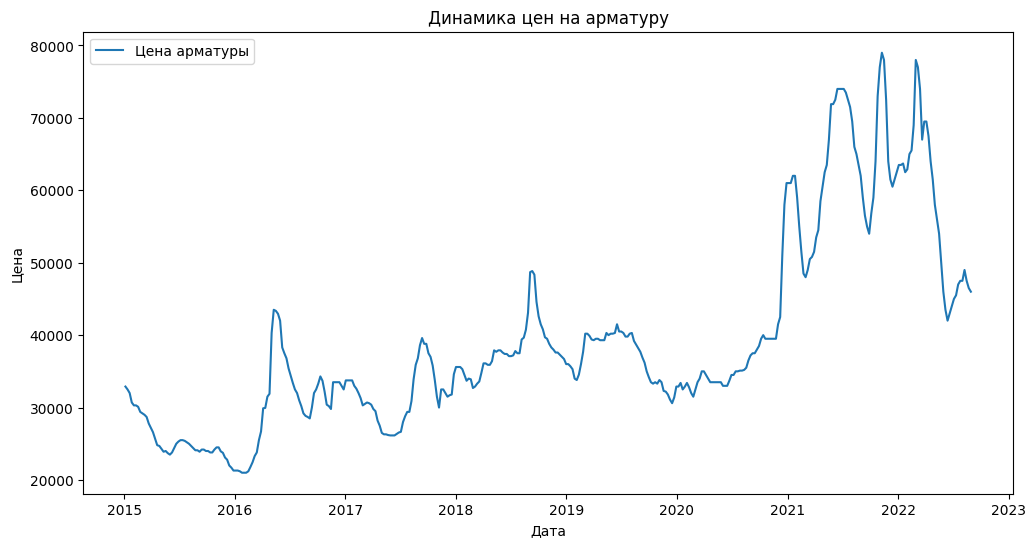

In [28]:

# Визуализируем временной ряд
plt.figure(figsize=(12, 6))
plt.plot(train['date'], train['price'], label='Цена арматуры')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Динамика цен на арматуру')
plt.legend()
plt.show()



Генерация признаков

In [29]:
# Генерация признаков
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['week'] = train['date'].dt.isocalendar().week
train['dayofyear'] = train['date'].dt.dayofyear

# Подготовка данных для обучения модели
X = train[['year', 'month', 'week', 'dayofyear']]
y = train['price']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


Обучение модели CatBoost и её оценка

In [30]:
# Обучение модели CatBoost
model = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, verbose=100)
model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=50)

# Оценка модели
preds = model.predict(X_valid)
mae = mean_absolute_error(y_valid, preds)
print(f'MAE: {mae}')



0:	learn: 13104.8551887	test: 12284.5734123	best: 12284.5734123 (0)	total: 2.1ms	remaining: 1.05s
100:	learn: 3175.3191170	test: 4011.1418784	best: 4011.1418784 (100)	total: 72.2ms	remaining: 285ms
200:	learn: 1957.1580666	test: 2866.2741216	best: 2866.2741216 (200)	total: 161ms	remaining: 239ms
300:	learn: 1353.4262688	test: 2341.4057555	best: 2341.4057555 (300)	total: 271ms	remaining: 179ms
400:	learn: 1030.8930269	test: 2053.3044416	best: 2053.3044416 (400)	total: 352ms	remaining: 86.9ms
499:	learn: 835.6713845	test: 1921.0449875	best: 1921.0449875 (499)	total: 439ms	remaining: 0us

bestTest = 1921.044987
bestIteration = 499

MAE: 1397.7907781501012


Генерация признаков для тестовых данных

In [31]:
# Генерация признаков для тестовых данных
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['week'] = test['date'].dt.isocalendar().week
test['dayofyear'] = test['date'].dt.dayofyear

test_preds = model.predict(test[['year', 'month', 'week', 'dayofyear']])
test['predicted_price'] = test_preds

# Сохранение результата
test.to_excel('test_predicted.xlsx', index=False)
print('Результат сохранен в test_predicted.xlsx')

Результат сохранен в test_predicted.xlsx


Загружаем и выводим предсказанный файл

In [ ]:
# Загружаем и выводим предсказанный файл test_predicted.xlsx
predicted_test = pd.read_excel("test_predicted.xlsx")
predicted_test

,date,price,year,month,week,dayofyear,predicted_price
0,2022-09-05,46000,2022,9,36,248,42846.670219
1,2022-09-12,46000,2022,9,37,255,40728.857132
2,2022-09-19,46000,2022,9,38,262,40288.046605
3,2022-09-26,45500,2022,9,39,269,40454.688713
4,2022-10-03,45500,2022,10,40,276,42514.100199
5,2022-10-10,45000,2022,10,41,283,43410.718570
6,2022-10-17,44000,2022,10,42,290,47618.305429
7,2022-10-24,43000,2022,10,43,297,54523.543796
8,2022-10-31,42000,2022,10,44,304,56276.935532
9,2022-11-07,41500,2022,11,45,311,60350.015821
